In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import dataframe_image as dfi


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import metrics
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

In [30]:
model = pd.read_csv("model.csv", low_memory = False)

In [31]:
# THE NUMBER OF FEATURES
len(model.columns)

207

In [32]:
# DROPPING NULLS
# model.isnull().sum().sort_values(ascending = False)
model = model.dropna()

In [33]:
# TOTAL ROWS
len(model)

586650

In [34]:
# HEATMAP
#plt.figure(figsize=(12,10))
#sns.heatmap(model.corr())

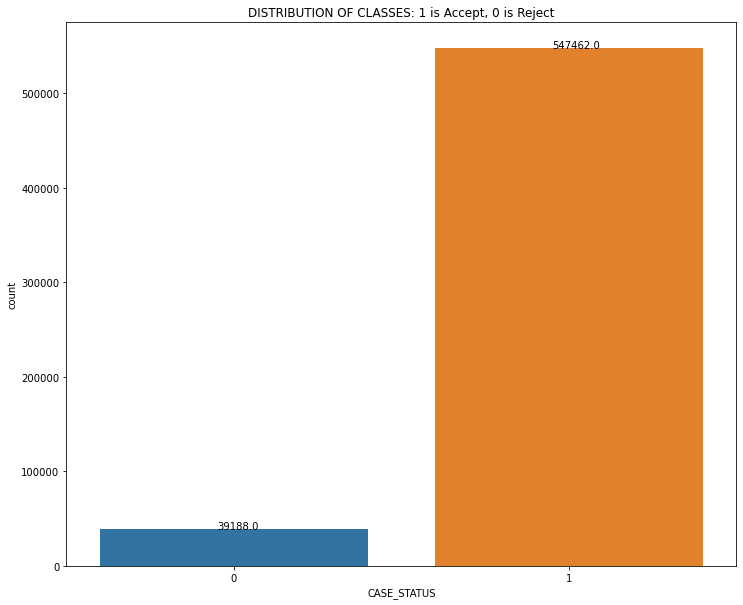

In [35]:
# DISTRIBUTION OF CLASSES
plt.figure(figsize=(12,10))
plt.title("DISTRIBUTION OF CLASSES: 1 is Accept, 0 is Reject")
ax = sns.countplot(x = model["CASE_STATUS"])
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.01))

In [36]:
model = pd.read_csv("model.csv")
model = model.dropna()
X = model.drop("CASE_STATUS",axis = 1)
y = model["CASE_STATUS"]


In [37]:
##### DEEP LEARNING CLASSIFICATION ####

In [38]:
# Preprocessing Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Creating Model: dm2
dm2 = Sequential()

dm2.add(Dense(100,activation = "relu"))
#dm2.add(Dropout(.2))
dm2.add(Dense(50,activation = "relu"))
#dm2.add(Dropout(.2))
dm2.add(Dense(1,activation = "sigmoid"))

dm2.compile(optimizer = "adam", loss = "binary_crossentropy", )
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 10)


# Training DLM1
dm2.fit(x = X_train, y = y_train, epochs = 500,validation_data = (X_test,y_test), callbacks = [early_stop], batch_size = 32)

Epoch 1/500
13750/13750 [==============================] - 28s 2ms/step - loss: 0.2161 - val_loss: 0.2124
Epoch 2/500
13750/13750 [==============================] - 26s 2ms/step - loss: 0.2093 - val_loss: 0.2086
Epoch 3/500
13750/13750 [==============================] - 25s 2ms/step - loss: 0.2056 - val_loss: 0.2045
Epoch 4/500
13750/13750 [==============================] - 26s 2ms/step - loss: 0.2017 - val_loss: 0.2034
Epoch 5/500
13750/13750 [==============================] - 26s 2ms/step - loss: 0.1993 - val_loss: 0.2022
Epoch 6/500
13750/13750 [==============================] - 26s 2ms/step - loss: 0.1972 - val_loss: 0.2008
Epoch 7/500
13750/13750 [==============================] - 26s 2ms/step - loss: 0.1955 - val_loss: 0.1991
Epoch 8/500
13750/13750 [==============================] - 26s 2ms/step - loss: 0.1933 - val_loss: 0.1992
Epoch 9/500
13750/13750 [==============================] - 26s 2ms/step - loss: 0.1909 - val_loss: 0.1962
Epoch 10/500
13750/13750 [====================

<AxesSubplot:>

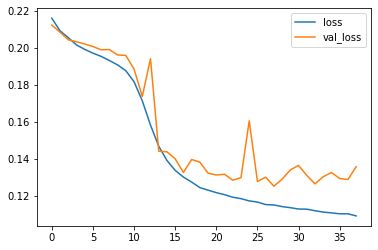

In [39]:
# Overfitting?
pd.DataFrame(dm2.history.history).plot()

In [40]:
# Evaluating DLM1
pdm2 = (dm2.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, pdm2))
print(confusion_matrix(y_test, pdm2))

4584/4584 [==============================] - 5s 1ms/step
              precision    recall  f1-score   support

           0       0.81      0.55      0.65      9878
           1       0.97      0.99      0.98    136785

    accuracy                           0.96    146663
   macro avg       0.89      0.77      0.82    146663
weighted avg       0.96      0.96      0.96    146663

[[  5410   4468]
 [  1278 135507]]


In [41]:
##### ML Classification Models ####

In [42]:
### RANDOM FOREST ###

In [45]:
# OVER SAMPLING THE MINORITY (REJECT)
model = pd.read_csv("model.csv")
model = model.dropna()
X = model.drop("CASE_STATUS",axis = 1)
y = model["CASE_STATUS"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

X = pd.concat([X_train, y_train], axis=1)
reject = X[X["CASE_STATUS"]==0]
accept = X[X["CASE_STATUS"]==1]

reject_o = resample(reject,replace=True,n_samples=len(accept),random_state=0)
new = pd.concat([accept, reject_o])

# RETEST
y_train = new["CASE_STATUS"]
X_train = new.drop("CASE_STATUS", axis=1)
rfco = RandomForestClassifier(n_estimators = 100, random_state = 0).fit(X_train, y_train)
predo = rfco.predict(X_test)
print(confusion_matrix(y_test,predo))
print(classification_report(y_test,predo))

[[  5222   4656]
 [   464 136321]]
              precision    recall  f1-score   support

           0       0.92      0.53      0.67      9878
           1       0.97      1.00      0.98    136785

    accuracy                           0.97    146663
   macro avg       0.94      0.76      0.83    146663
weighted avg       0.96      0.97      0.96    146663



In [46]:
# UNDER SAMPLING THE MAJORITY (ACCEPT)
model = pd.read_csv("model.csv")
model = model.dropna()
X = model.drop("CASE_STATUS",axis = 1)
y = model["CASE_STATUS"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

X = pd.concat([X_train, y_train], axis=1)
reject = X[X["CASE_STATUS"]==0]
accept = X[X["CASE_STATUS"]==1]

accept_u = resample(accept, replace = False, n_samples = len(reject), random_state = 0) 
new = pd.concat([accept_u, reject])

# RETEST
y_train = new["CASE_STATUS"]
X_train = new.drop("CASE_STATUS", axis=1)
rfcu = RandomForestClassifier(n_estimators = 100, random_state = 0).fit(X_train, y_train)
predu = rfcu.predict(X_test)
print(confusion_matrix(y_test,predu))
print(classification_report(y_test,predu))

[[  8104   1774]
 [ 16785 120000]]
              precision    recall  f1-score   support

           0       0.33      0.82      0.47      9878
           1       0.99      0.88      0.93    136785

    accuracy                           0.87    146663
   macro avg       0.66      0.85      0.70    146663
weighted avg       0.94      0.87      0.90    146663



In [47]:
# SMOTE
model = pd.read_csv("model.csv")
model = model.dropna()
X = model.drop("CASE_STATUS",axis = 1)
y = model["CASE_STATUS"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)
smote = RandomForestClassifier(n_estimators = 100, random_state = 0).fit(X_train, y_train)

pred = smote.predict(X_test)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[  5323   4555]
 [   666 136119]]
              precision    recall  f1-score   support

           0       0.89      0.54      0.67      9878
           1       0.97      1.00      0.98    136785

    accuracy                           0.96    146663
   macro avg       0.93      0.77      0.83    146663
weighted avg       0.96      0.96      0.96    146663



In [48]:
#RANDOM FOREST 
model = pd.read_csv("model.csv")
model = model.dropna()
X = model.drop("CASE_STATUS",axis = 1)
y = model["CASE_STATUS"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
# RANDOM FOREST 1: RF1
rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf.fit(X_train,y_train)
prf = rf.predict(X_test)
print(confusion_matrix(y_test,prf))
print(classification_report(y_test,prf))

[[  4995   4883]
 [   229 136556]]
              precision    recall  f1-score   support

           0       0.96      0.51      0.66      9878
           1       0.97      1.00      0.98    136785

    accuracy                           0.97    146663
   macro avg       0.96      0.75      0.82    146663
weighted avg       0.96      0.97      0.96    146663



In [ ]:
#gbc=HistGradientBoostingClassifier(learning_rate=0.01, 
#        max_iter=2000, max_leaf_nodes=6, validation_fraction=0.2, 
#        n_iter_no_change=15, random_state=0).fit(X_train,y_train)
#
#predtst=gbc.predict_proba(X_test)[:,1]
#fpr, tpr, thresholds = metrics.roc_curve(y_test, predtst)
#dfplot=pd.DataFrame({'Threshold':thresholds, 
#        'False Positive Rate':fpr, 
#        'False Negative Rate': 1.-tpr})

In [ ]:
#ax=dfplot.plot(x='Threshold', y=['False Positive Rate',
#        'False Negative Rate'], figsize=(10,6))
#ax.plot([0.75,0.1],[0,0.1]) #mark example thresh.
#ax.set_xbound(0.905,.907); ax.set_ybound(.31,0.38) #zoom in

In [ ]:
#threshtest = np.where(predtst >= 0.90625, 1, 0)
#print(confusion_matrix(y_test,threshtest))
#print(classification_report(y_test,threshtest))

In [ ]:
# GridSearch CV for RFC
#model = pd.read_csv("model.csv")
#model = model.dropna()
#X = model.drop("CASE_STATUS",axis = 1)
#y = model["CASE_STATUS"]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

#rfc = RandomForestClassifier(random_state = 0)
#parameters = {"n_estimators":[10,50,100,200],"max_depth":[2,4,8,10],"max_features": ['sqrt', 'log2'],
#    "criterion" :['gini', 'entropy']}

#cv = GridSearchCV(rfc,parameters,cv=5)
#cv.fit(X_train,y_train)
#cv.best_params_

In [ ]:
#RANDOM FOREST 
#model = pd.read_csv("model.csv")
#model = model.dropna()
#X = model.drop("CASE_STATUS",axis = 1)
#y = model["CASE_STATUS"]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
# RANDOM FOREST 1: RF1
#rfcv = RandomForestClassifier(n_estimators = 50, random_state = 0, criterion="gini",max_depth = 10, max_features= "sqrt")
#rfcv.fit(X_train,y_train)
#prfcv = rfcv.predict(X_test)
#print(confusion_matrix(y_test,prfcv))
#print(classification_report(y_test,prfcv))